In [2]:
import torch
from torch_snippets import *
from torchvision import transforms as T
from torch.nn import functional as F
from torch import nn
from torchvision.models import vgg19
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
preprocess = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=[.485, .456, .406], std=[.229, .224, .225]),
        T.Lambda(lambda x: x.mul_(255))
    ]
)
postprocess = T.Compose(
    [
        T.Lambda(lambda x: x.mul_(1./255)),
        T.Normalize(mean=[-.485/.229, -.456/.224, -.406/.225], std=[1/.229, 1/.224, 1/.225])
    ]
)

In [4]:
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        feat = input.view(b, c, h*w)
        G = feat@feat.transpose(1, 2)
        G.div_(h*w)
        return G

In [5]:
class GramSELoss(nn.Module):
    def forward(self, input, target):
        out = F.mse_loss(GramMatrix()(input), target)
        return(out)

In [6]:
class vgg19_modified(nn.Module):
    def __init__(self):
        super().__init__()
        features = list(vgg19(pretrained = True).features)
        self.features = nn.ModuleList(features).eval()
    
    def forward(self, x, layers=[]):
        order = np.argsort(layers)
        _results, results = [], []
        for ix, model in enumerate(self.features):
            x = model(x)
            if ix in layers: _results.append(x)
        for o in order: results.append(_results[o])
        return results if layers is not [] else x

In [7]:
vgg = vgg19_modified().to(device)

/home/zanchet/src/Solutions_LAMIA/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zanchet/src/Solutions_LAMIA/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
original_image_url = "https://www.artesanatopassoapassoja.com.br/wp-content/uploads/2020/08/desenho-de-girafa-colorido.jpg"
#original_image_url = "https://easydrawingguides.com/wp-content/uploads/2016/10/how-to-draw-an-elephant-featured-image-1200-1024x822.png"

original_image_file = "original_image.jpg"
!rm {original_image_file}
l = !wget -O {original_image_file} {original_image_url}

In [18]:
style_image_url = "https://heavy.com/wp-content/uploads/2016/05/4805137133_e7e2213a91_o.jpg"
#style_image_url = "https://www.neh.gov/sites/default/files/2022-09/Fall_2022_web-images_Picasso_32.jpg"
style_image_url = "https://as1.ftcdn.net/v2/jpg/05/71/27/84/1000_F_571278490_7on7u2haJpvDpcYSp3Kxf1QQ496Xp9wa.jpg"
style_image_file = "style_image.jpg"
!rm {style_image_file}
l = !wget -O {style_image_file} {style_image_url}

In [19]:
paths = [style_image_file, original_image_file]

In [20]:
paths

['style_image.jpg', 'original_image.jpg']

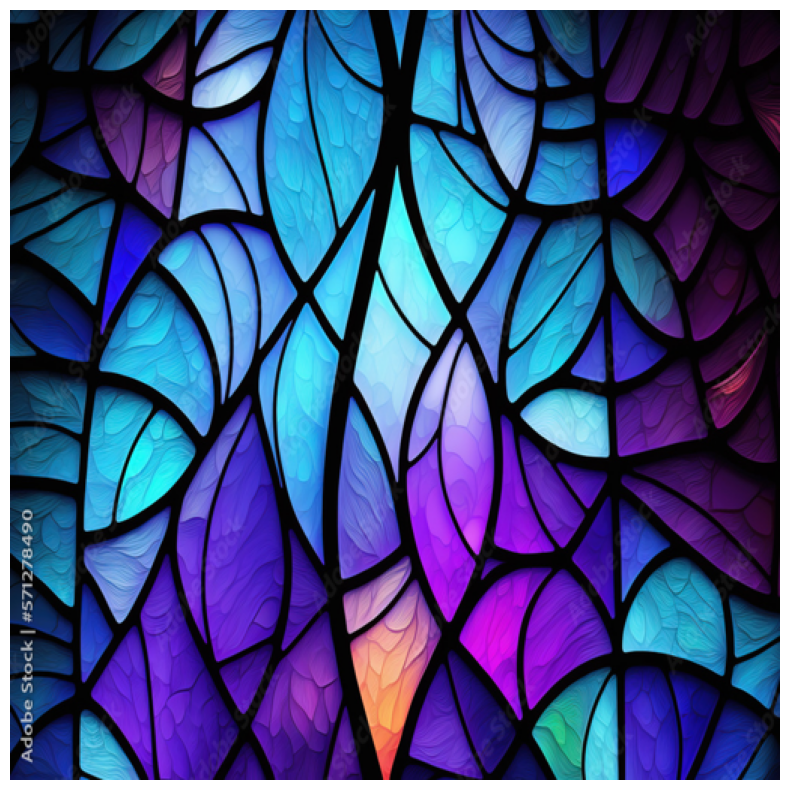

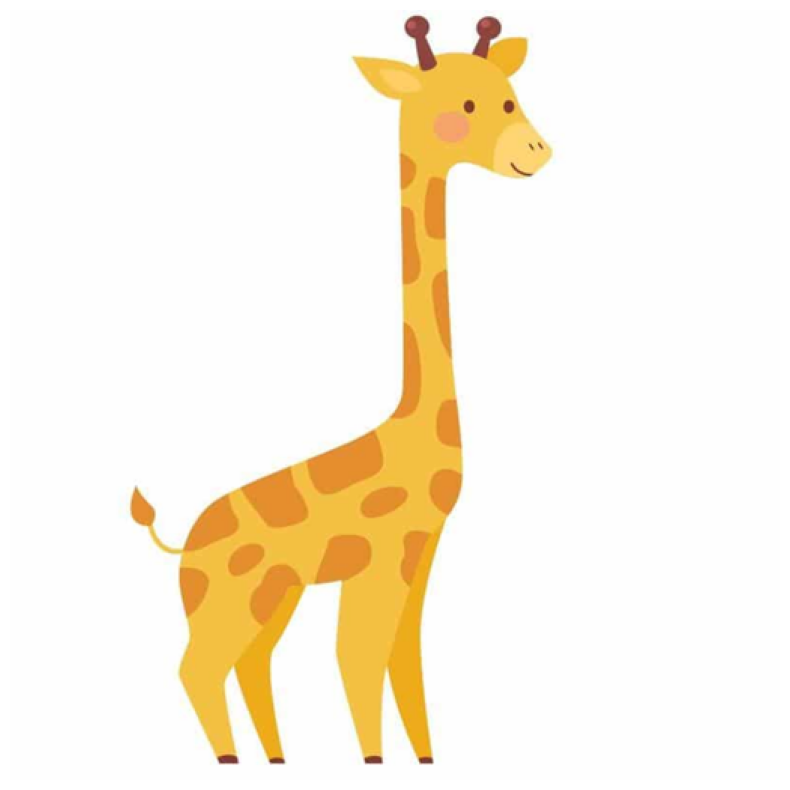

In [21]:
imgs = [Image.open(path).resize((512, 512)).convert('RGB') for path in paths]
show(imgs[0])
show(imgs[1])

In [22]:
np.asarray(imgs[0]).shape

(512, 512, 3)

In [23]:
style_image, content_image = [preprocess(img).to(device)[None] for img in imgs]

In [24]:
opt_img = content_image.data.clone()
opt_img.requires_grad = True

In [25]:
style_layers = [0, 5, 10, 19, 28]
content_layers = [21]
loss_layers = style_layers + content_layers

In [26]:
loss_fns = [GramSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
loss_fns = [loss_fn.to(device) for loss_fn in loss_fns]

In [27]:
style_weights = [1000/n**2 for n in [64, 128, 256, 512, 512]]
content_weights = [1]
weights = style_weights + content_weights

In [28]:
style_image.shape

torch.Size([1, 3, 512, 512])

In [29]:
np.asarray(style_layers).shape

(5,)

In [30]:
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [31]:
max_iters = 500
optimizer = torch.optim.LBFGS([opt_img])

In [32]:
iters = 0
while iters < max_iters:
    def closure():
        global iters
        iters += 1
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a, A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        return loss
    optimizer.step(closure)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1215608..2.3293571].


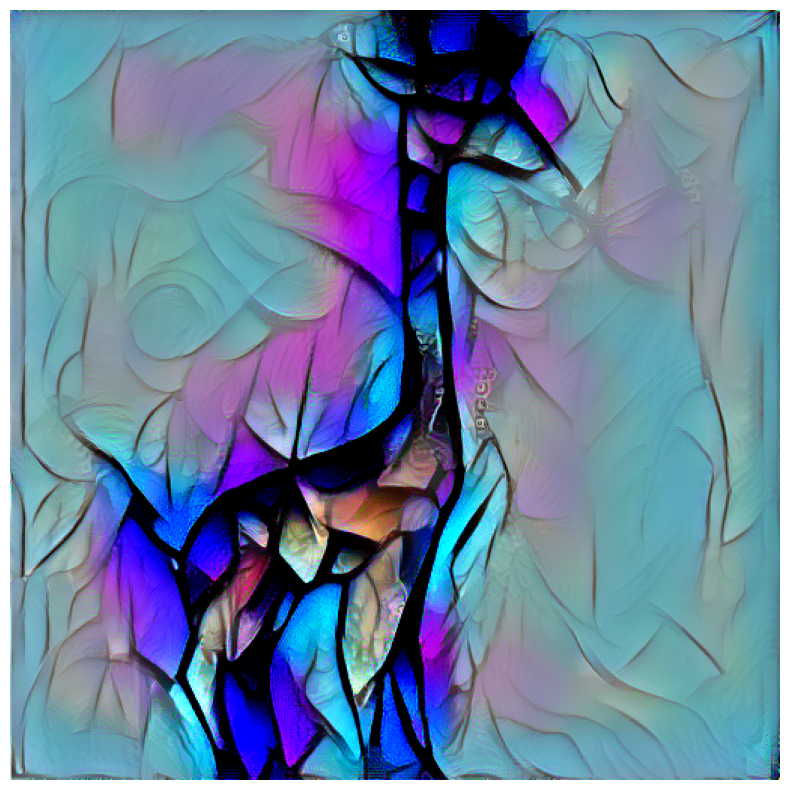

In [33]:
with torch.no_grad():
    out_img = postprocess(opt_img[0]).permute(1,2,0)
show(out_img)